In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [36]:
# Set the paths for the dataset
image_dir = 'images/'
mask_dir = 'masks/'

# Get a list of image and mask files
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

In [37]:
print("Image Directory:", image_dir)
print("Mask Directory:", mask_dir)

Image Directory: images/
Mask Directory: masks/


In [38]:
def load_images(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []

    # Get a list of image and mask files, filtering out hidden files
    image_files = [f for f in sorted(os.listdir(image_dir)) if not f.startswith('.')]
    mask_files = [f for f in sorted(os.listdir(mask_dir)) if not f.startswith('.')]

    if len(image_files) != len(mask_files):
        print("Warning: The number of images and masks does not match.")

    for img_file, mask_file in zip(image_files, mask_files):
        # Load images
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = cv2.imread(img_path)
        if img is None:
            print(f"Error loading image: {img_path}")
            continue  # Skip this iteration if the image is not found

        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize to [0, 1]

        # Load masks
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Error loading mask: {mask_path}")
            continue  # Skip this iteration if the mask is not found

        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0  # Normalize to [0, 1]
        mask = np.where(mask > 0.5, 1.0, 0.0)  # Binarize masks

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

images, masks = load_images(image_dir, mask_dir)

In [39]:
print("Image files:", image_files)
print("Mask files:", mask_files)

Image files: ['.ipynb_checkpoints', 'HipHop_HipHop1_C0_00180.png', 'HipHop_HipHop1_C0_00225.png', 'HipHop_HipHop1_C0_00360.png', 'HipHop_HipHop1_C0_00405.png', 'HipHop_HipHop1_C0_00450.png', 'HipHop_HipHop1_C0_00540.png', 'HipHop_HipHop1_C0_00585.png', 'HipHop_HipHop1_C0_00675.png', 'HipHop_HipHop1_C0_00720.png', 'HipHop_HipHop1_C0_00765.png', 'HipHop_HipHop1_C0_00810.png', 'HipHop_HipHop1_C1_00045.png', 'HipHop_HipHop1_C1_00090.png', 'HipHop_HipHop1_C1_00135.png', 'HipHop_HipHop1_C1_00180.png', 'HipHop_HipHop1_C1_00225.png', 'HipHop_HipHop1_C1_00270.png', 'HipHop_HipHop1_C1_00315.png', 'HipHop_HipHop1_C1_00360.png', 'HipHop_HipHop1_C1_00405.png', 'HipHop_HipHop1_C1_00450.png', 'HipHop_HipHop1_C1_00495.png', 'HipHop_HipHop1_C1_00540.png', 'HipHop_HipHop1_C1_00585.png', 'HipHop_HipHop1_C1_00630.png', 'HipHop_HipHop1_C1_00675.png', 'HipHop_HipHop1_C1_00720.png', 'HipHop_HipHop1_C1_00765.png', 'HipHop_HipHop1_C1_00810.png', 'HipHop_HipHop1_C2_00045.png', 'HipHop_HipHop1_C2_00090.png', 'Hi

In [40]:
print(f"Loaded {len(images)} images and {len(masks)} masks.")

Loaded 1192 images and 1192 masks.


In [41]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [42]:
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()

In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=16)

Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 919ms/step - accuracy: 0.9255 - loss: 0.3454 - val_accuracy: 0.9570 - val_loss: 0.1565
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 73s 215ms/step - accuracy: 0.9584 - loss: 0.1394 - val_accuracy: 0.9570 - val_loss: 0.1090
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.9602 - loss: 0.1021 - val_accuracy: 0.9750 - val_loss: 0.0740
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 219ms/step - accuracy: 0.9639 - loss: 0.1045 - val_accuracy: 0.9571 - val_loss: 0.1260
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.9618 - loss: 0.1024 - val_accuracy: 0.9649 - val_loss: 0.0962
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - accuracy: 0.9659 - loss: 0.1054 - val_accuracy: 0.9699 - val_loss: 0.0827
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.9726 - loss: 0.0742 - val_accuracy: 0.9812 - val_loss: 0.0443
Epoch 8/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.9831 - loss: 0.0399 - val_accu

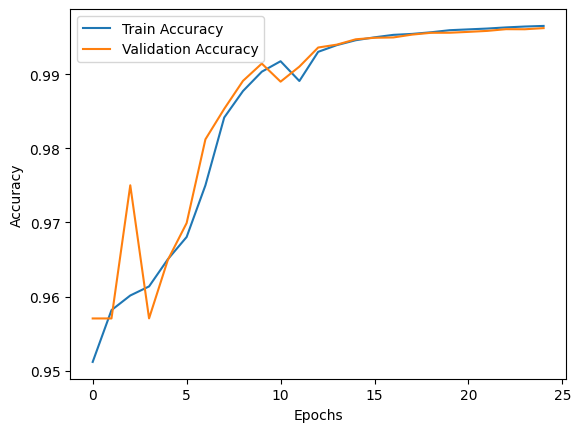

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step


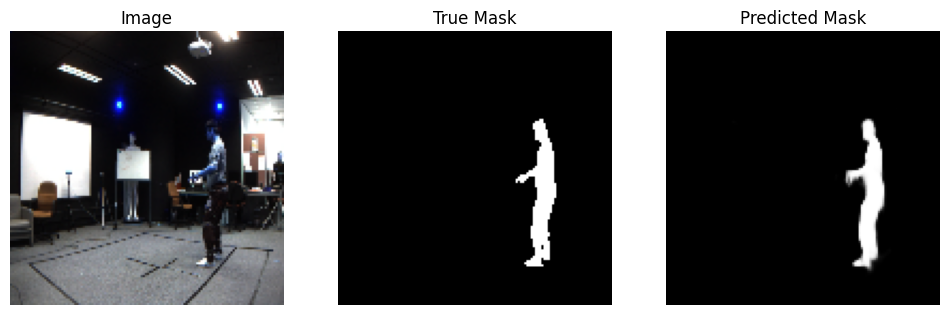

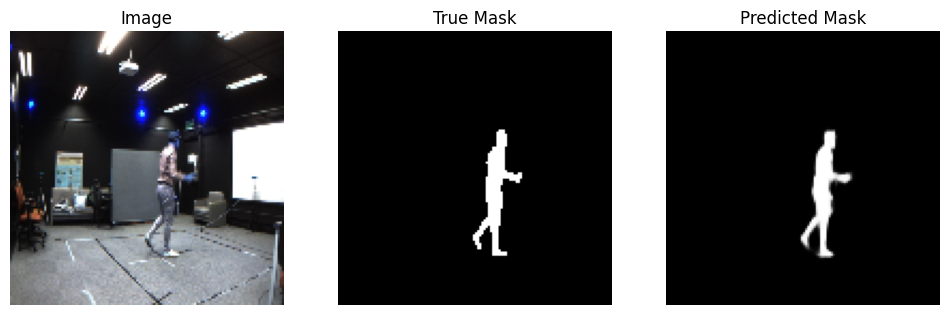

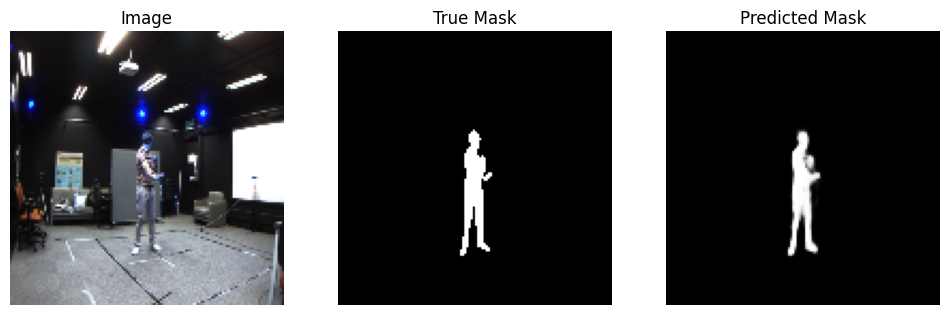

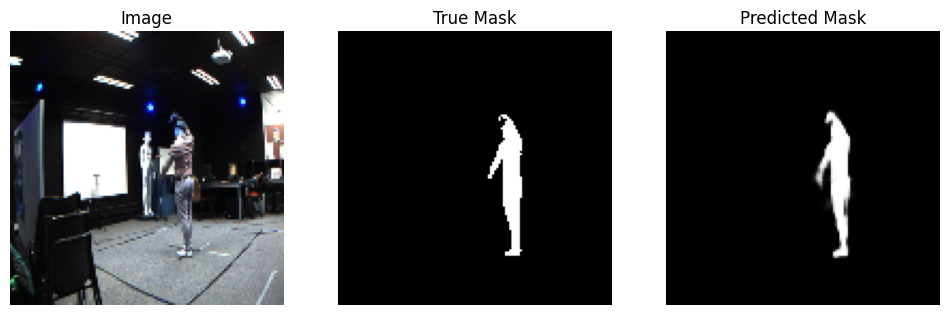

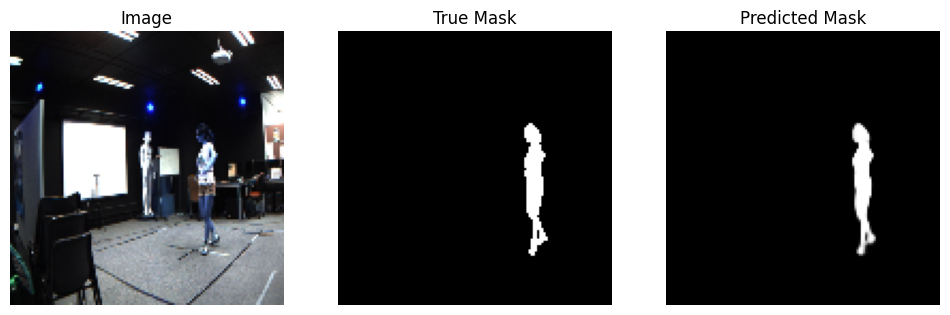

In [45]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

# Make predictions
predictions = model.predict(X_val)

# Visualize some predictions
for i in range(5):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(X_val[i])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()